# [Demo] Identification of the $\pi$ pulse

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle#1|}$
$\newcommand{\ketbra}[2]{| #1 \rangle\langle #2 |}$

In [1]:
import os
import copy
import logging
import numpy as np
import scipy.optimize as sciopt
from scipy.fft import fft
import matplotlib.pyplot as plt
import rqutils.paulis as paulis
import qudit_sim

qudit_sim.config.jax_devices = [0, 1]

try:
    os.mkdir('pi_pulse')
except FileExistsError:
    pass

## System Hamiltonian

We will run the simulations in the ququadrit space and extract qutrit operators from the results.

In [2]:
hgen = qudit_sim.HamiltonianBuilder(4)
hgen.add_qudit(qubit_frequency=3.e+10, anharmonicity=-2.e+9, drive_amplitude=1.5e+9, qudit_id='q0')

## Effective Hamiltonian of a qubit-resonant drive

First we apply a constant drive and identify which terms are present in the qutrit effective Hamiltonian.

In [3]:
drive_frequency_01 = hgen.dressed_frequencies('q0')[0]
test_amplitude = 0.2

res01_components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_01, amplitude=test_amplitude,
                                            cycles=400, comp_dim=3, save_result_to='pi_pulse/res01', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.000e+00 to 1.047e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 2.037173 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to pi_pulse/res01_sim.qu
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 126 steps.


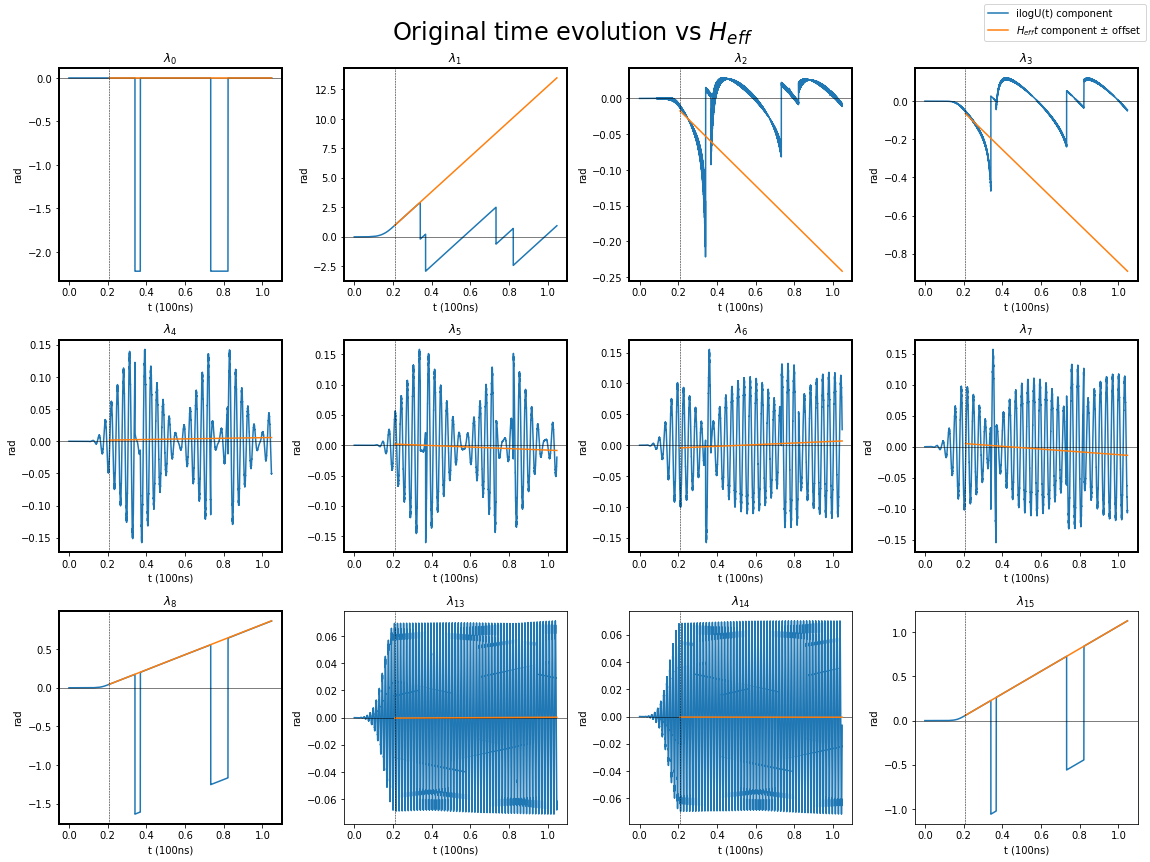

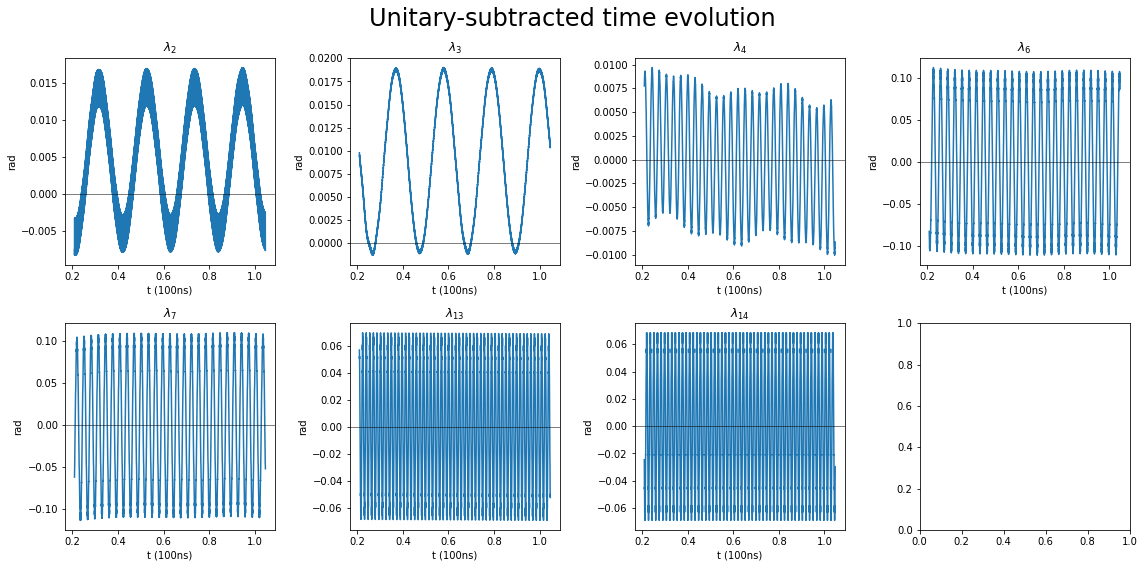

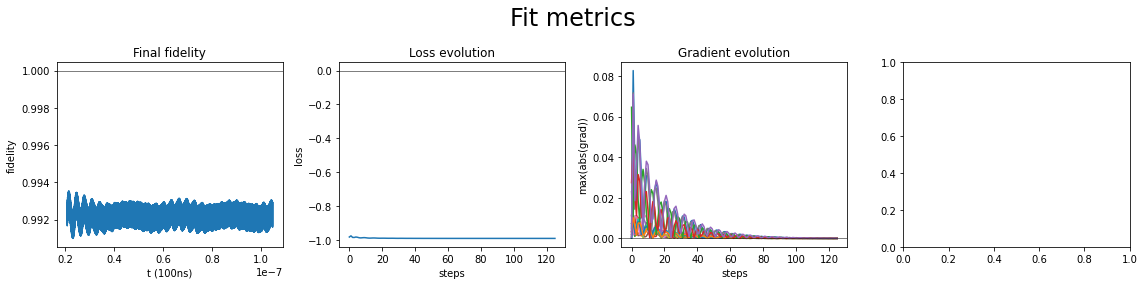

In [4]:
qudit_sim.visualization.inspect_heff_fit('pi_pulse/res01_heff.h5');

We see no long-term linear trends in the unitary-subtracted time evolution. Looks like the fit worked.

In [5]:
qudit_sim.visualization.print_components(res01_components)

<IPython.core.display.Latex object>

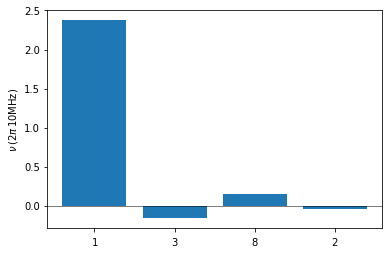

In [6]:
qudit_sim.visualization.plot_components(res01_components);

Qubit-resonant drive is an off-resonant drive for the 1<->2 transition, generating an AC Stark term $\mathrm{diag}(0, 1, -1) = \sqrt{3}\lambda_8/2 - \lambda_3/2$.

## Amplitude scan of qubit-resonant drive

We try to see if there is an amplitude that maximally suppresses $\sqrt{3}\lambda_8 - \lambda_3$ with respect to $\lambda_1$.

In [7]:
amplitudes = np.linspace(-0.3, 0.3, 20)

components_list = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_01, amplitude=amplitudes, cycles=400, comp_dim=3, log_level=logging.INFO)

INFO:qudit_sim.parallel:Executing pulse_sim in 20 parallel (max 64 simultaneous) processes..
INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.000e+00 to 1.047e-07
INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.000e+00 to 1.047e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.000e+00 to 1.047e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.000e+00 to 1.047e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.000e+00 to 1.047e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.000e+00 to 1.047e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Using 8001 time points from 0.0

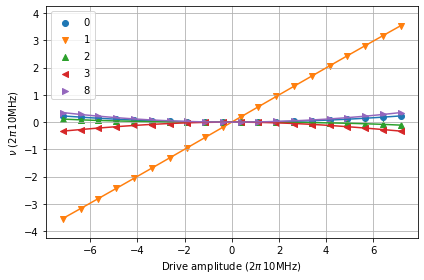

In [8]:
amp_base = hgen.qudit_params('q0').drive_amplitude
physical_amps = amp_base * amplitudes
fig, coefficients, amp_scale, compo_scale = qudit_sim.visualization.plot_amplitude_scan(physical_amps, components_list)

(0.0, 0.15)

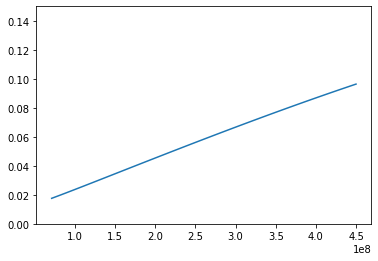

In [9]:
amplitudes_fine = np.linspace(physical_amps[11], physical_amps[-1], 100)
poly = lambda idx, x: np.sum(coefficients[idx] * np.power(np.asarray(x)[:, None] / amp_scale.pulsatance_value, np.arange(5)), axis=1)
poly_amp = lambda idx: poly(idx, amplitudes_fine)
ratio_z12_to_x = (poly_amp(8) - poly_amp(3)) * 0.5 / poly_amp(1)
plt.plot(amplitudes_fine, ratio_z12_to_x, label='$Z_{12}/X$')
plt.ylim(0., 0.15)

Unfortunately, the ratio increases monotonically with the amplitude. We will have to just cancel $\sqrt{3}\lambda_8 - \lambda_3$ by e.g. using DRAG.

## Gaussian pulse

We will ultimately find a DRAG pulse to implement $R_x(\pi)$, but we start with a Gaussian with a fixed duration and find the amplitude that gets us close to $\pi$.

In [10]:
hgen.clear_drive()

unit_time = 0.2e-9

duration_01 = unit_time * 160
sigma_01 = unit_time * 40

This pulse has a line width of $1/\sigma = 125 \mathrm{Mrad/s}$ in the frequency domain, which means that the $\ket{1}\leftrightarrow\ket{2}$ transition frequency is 16 sigmas away.

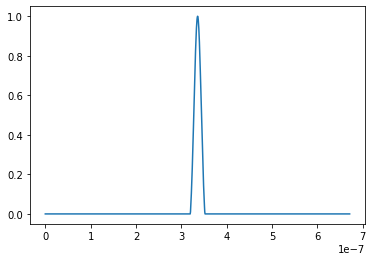

In [11]:
pulse_seq = qudit_sim.pulse.PulseSequence([
    qudit_sim.pulse.Delay(duration_01 * 10.),
    qudit_sim.pulse.Gaussian(duration=duration_01, amp=1., sigma=sigma_01),
    qudit_sim.pulse.Delay(duration_01 * 10.)
])

num_samples = 2**10

tpoints = np.linspace(0., 1., num_samples, endpoint=False) * pulse_seq.duration
time_domain = pulse_seq.envelope(tpoints).real
plt.plot(tpoints, time_domain);

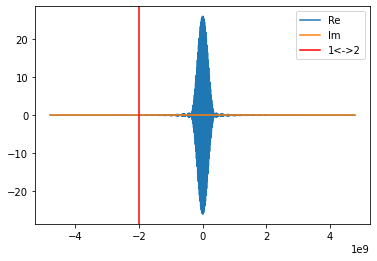

In [12]:
omegapoints = np.arange(-num_samples // 2, num_samples // 2).astype(float) * 2. * np.pi / pulse_seq.duration
frequency_domain = np.roll(fft(time_domain), num_samples // 2)
plt.plot(omegapoints, frequency_domain.real, label='Re')
plt.plot(omegapoints, frequency_domain.imag, label='Im')
q0 = hgen.qudit_params('q0')
plt.axvline(q0.anharmonicity, color='red', label='1<->2')
plt.legend();

In [13]:
# approximate the Gaussian with a triangle -> area = amp * duration / 2.
rough_amp_estimate = np.pi / 2. / (res01_components[1] / test_amplitude * duration_01 / 2.)
rough_amp_estimate

0.13157893594587192

In [14]:
amplitudes = rough_amp_estimate * np.linspace(0.8, 1.2, 20)
pulses = list(qudit_sim.pulse.Gaussian(duration=duration_01, amp=amp, sigma=sigma_01) for amp in amplitudes)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_01)

# drive_frequency_01 is actually angular frequency
cycle = 1. / drive_frequency_01 * 2. * np.pi
num_tpoints = int(duration_01 / cycle) * 16
tlist = np.linspace(0., duration_01, num_tpoints)

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, log_level=logging.INFO)
components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results))

INFO:qudit_sim.parallel:Executing _run_single in 20 parallel (max 64 simultaneous) processes..
INFO:qudit_sim.pulse_sim.0:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.1:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.0:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.2:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.1:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.3:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.2:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.3:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.4:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.5:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.4:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.6:Using

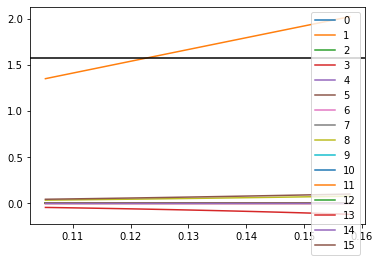

In [15]:
plt.plot(amplitudes, components_list, label=paulis.labels(4, norm=False, symbol=''))
plt.axhline(np.pi / 2., color='black')
plt.legend();

Gaussian amplitude at which the X component hits $\pi/2$:

In [16]:
halfpi = np.pi / 2.
idx = np.searchsorted(components_list[:, 1], halfpi)
y0, y1 = components_list[idx - 1:idx + 1, 1]
x0, x1 = amplitudes[idx - 1:idx + 1]
best_amplitude_01 = ((halfpi - y0) * x1 - (halfpi - y1) * x0) / (y1 - y0)
best_amplitude_01

0.12247131258380854

The best amplitude is somewhat smaller than the rough estimate.

In [17]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Gaussian(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01)
hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist)
best_01_gaus_components = qudit_sim.apps.gates.gate_components(sim_result)

In [18]:
qudit_sim.visualization.print_components(best_01_gaus_components, scale='pi')

<IPython.core.display.Latex object>

## DRAG pulse

Gaussian pulse effects non-negligible phase shifts due to the AC Stark shifts of $\ket{1} \leftrightarrow \ket{2}$ and $\ket{2} \leftrightarrow \ket{3}$ transitions. We seek to mitigate this effect by adding a derivative term to the pulse.

In [19]:
hgen.clear_drive()

betas = unit_time * np.linspace(0., 4., 20)
pulses = list(qudit_sim.pulse.Drag(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01, beta=beta) for beta in betas)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_01)

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, log_level=logging.INFO)
components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results))

INFO:qudit_sim.parallel:Executing _run_single in 20 parallel (max 64 simultaneous) processes..
INFO:qudit_sim.pulse_sim.0:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.1:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.0:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.2:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.1:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.3:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.2:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.4:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.3:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.5:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.4:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.6:Using

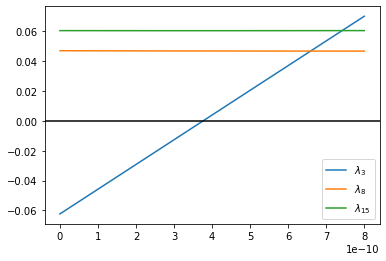

In [20]:
plt.plot(betas, components_list[:, 3], label=r'$\lambda_3$')
plt.plot(betas, components_list[:, 8], label=r'$\lambda_8$')
plt.plot(betas, components_list[:, 15], label=r'$\lambda_{15}$')
plt.axhline(0., color='black')
plt.legend();

We see that DRAG does not affect $\lambda_8$ and $\lambda_{15}$ components, but can change the $\lambda_3$ component linearly with respect to the $\beta$ parameter.

Here we make a choice; we want our $\pi$ pulse to be the $X$ in the qubit space. So we adjust $\beta$ to cancel $\lambda_3$ only.

In [21]:
idx = np.searchsorted(components_list[:, 3], 0.)
y0, y1 = components_list[idx - 1:idx + 1, 3]
x0, x1 = betas[idx - 1:idx + 1]
best_beta_01 = ((0. - y0) * x1 - (0. - y1) * x0) / (y1 - y0)
best_beta_01

3.7638157272295606e-10

In [22]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Drag(duration=duration_01, amp=best_amplitude_01, sigma=sigma_01, beta=best_beta_01)
hgen.add_drive('q0', frequency=drive_frequency_01, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, log_level=logging.INFO)
best_01_drag_components = qudit_sim.apps.gates.gate_components(sim_result)

INFO:qudit_sim.pulse_sim:Using 2432 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 0.661553 seconds.


In [23]:
qudit_sim.visualization.print_components(best_01_drag_components, scale='pi')

<IPython.core.display.Latex object>

$\lambda_3$ is gone. We might be able to go further and find ways to suppress $\lambda_8$ and $\lambda_{15}$, but for now we'll call this the $\pi$ pulse for $\ket{0}\leftrightarrow\ket{1}$.

## $\pi$ pulse for $\ket{1} \leftrightarrow \ket{2}$ transition

Let's go through the same exercise for $\ket{1} \leftrightarrow \ket{2}$.

In [24]:
hgen.clear_drive()

drive_frequency_12 = hgen.dressed_frequencies('q0')[1]
test_amplitude = 0.2

res12_components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency_12, amplitude=test_amplitude,
                                            cycles=400, comp_dim=3, save_result_to='pi_pulse/res12', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 8287 time points from 0.000e+00 to 1.122e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 2.103296 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to pi_pulse/res12_sim.qu
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 189 steps.


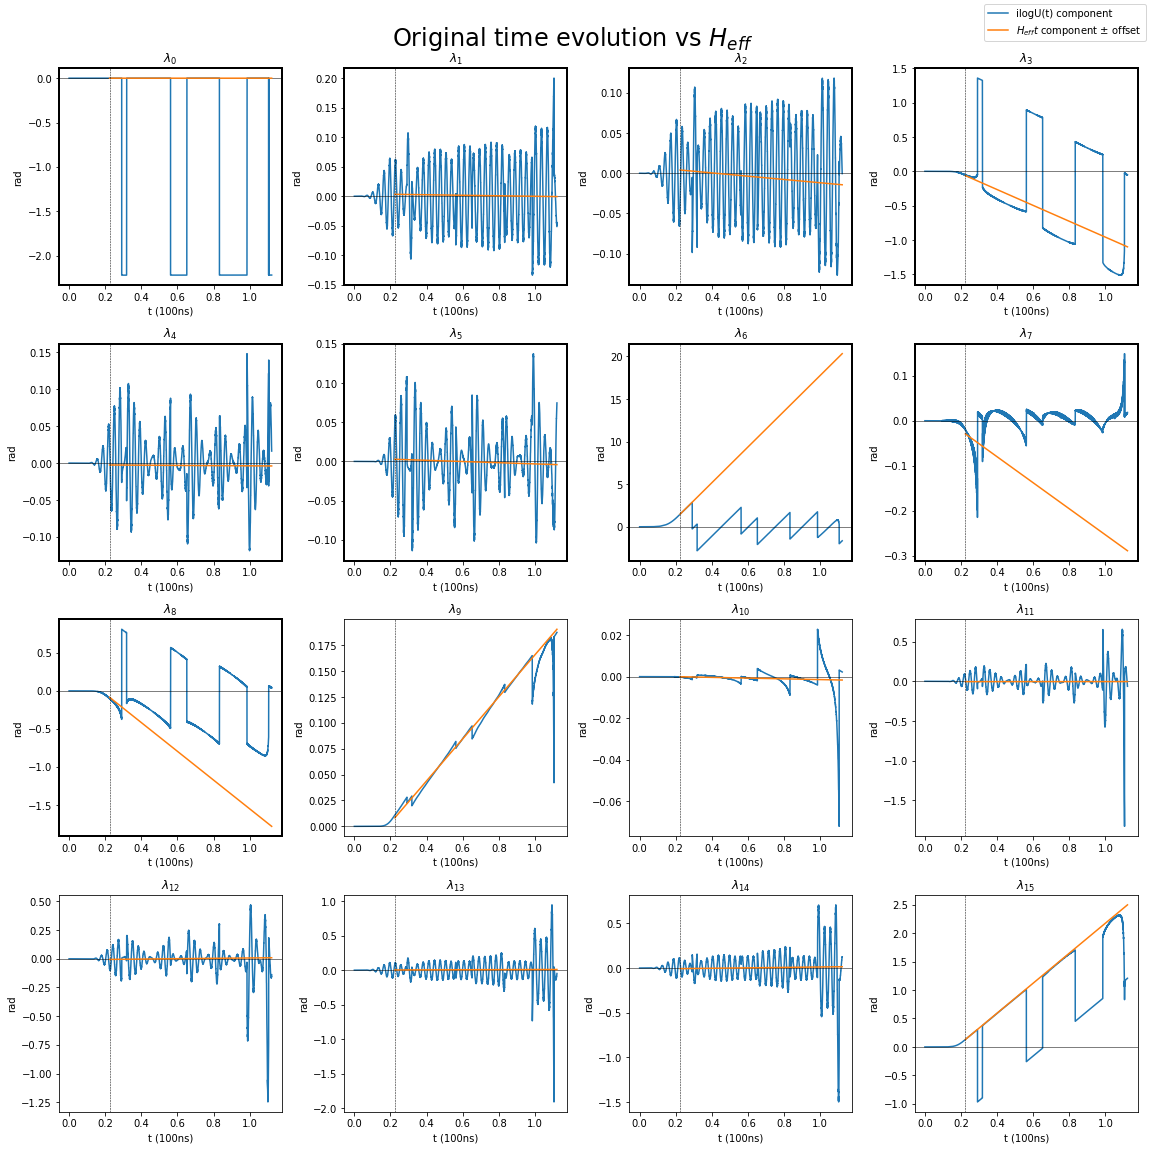

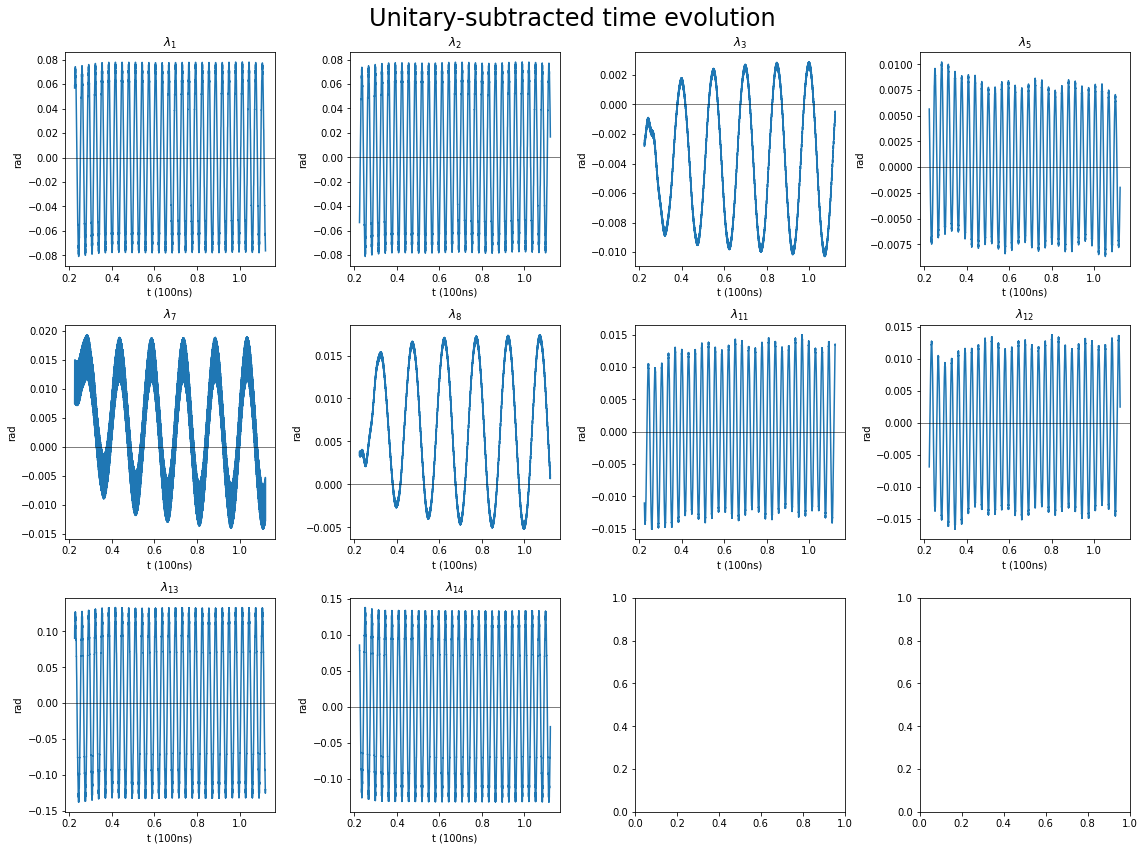

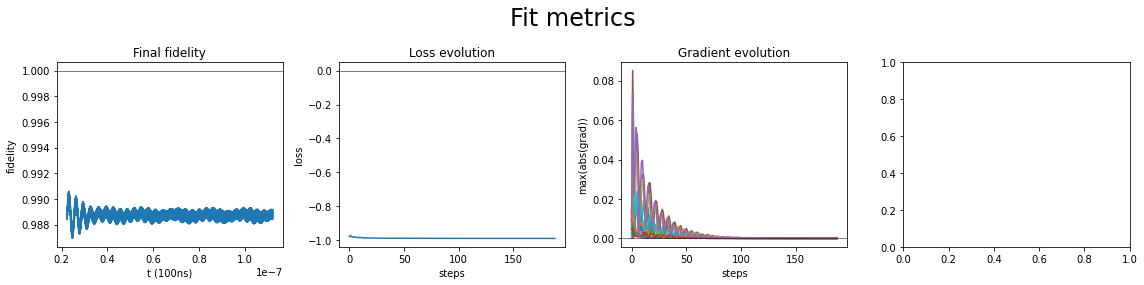

In [25]:
qudit_sim.visualization.inspect_heff_fit('pi_pulse/res12_heff.h5');

In [26]:
qudit_sim.visualization.print_components(res12_components)

<IPython.core.display.Latex object>

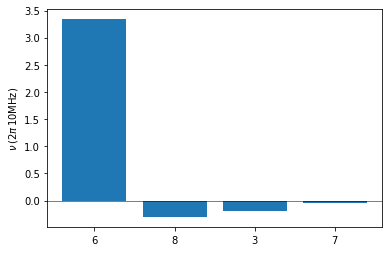

In [27]:
qudit_sim.visualization.plot_components(res12_components);

In [28]:
duration_12 = unit_time * 160
sigma_12 = unit_time * 40

hgen.clear_drive()

# approximate the Gaussian with a triangle -> area = amp * duration / 2.
rough_amp_estimate = np.pi / 2. / (res12_components[6] / test_amplitude * duration_12 / 2.)

amplitudes = rough_amp_estimate * np.linspace(0.8, 1.2, 20)
pulses = list(qudit_sim.pulse.Gaussian(duration=duration_12, amp=amp, sigma=sigma_12) for amp in amplitudes)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_12)

cycle = 1. / drive_frequency_12 * 2. * np.pi
num_tpoints = int(duration_12 / cycle) * 16
tlist = np.linspace(0., duration_12, num_tpoints)

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, log_level=logging.INFO)
components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results))

INFO:qudit_sim.parallel:Executing _run_single in 20 parallel (max 64 simultaneous) processes..
INFO:qudit_sim.pulse_sim.0:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.1:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.0:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.1:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.2:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.3:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.2:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.4:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.3:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.4:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.5:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.6:Using

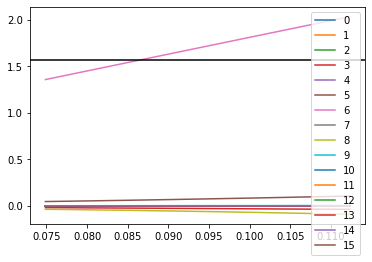

In [29]:
plt.plot(amplitudes, components_list, label=paulis.labels(4, norm=False, symbol=''))
plt.axhline(np.pi / 2., color='black')
plt.legend();

In [30]:
halfpi = np.pi / 2.
idx = np.searchsorted(components_list[:, 6], halfpi)
y0, y1 = components_list[idx - 1:idx + 1, 6]
x0, x1 = amplitudes[idx - 1:idx + 1]
best_amplitude_12 = ((halfpi - y0) * x1 - (halfpi - y1) * x0) / (y1 - y0)
best_amplitude_12

0.08658564594660485

In [31]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Gaussian(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12)
hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, log_level=logging.INFO)
best_12_gaus_components = qudit_sim.apps.gates.gate_components(sim_result)

INFO:qudit_sim.pulse_sim:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 0.639476 seconds.


In [32]:
qudit_sim.visualization.print_components(best_12_gaus_components, scale='pi')

<IPython.core.display.Latex object>

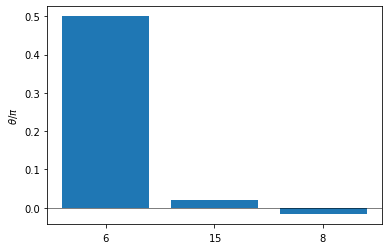

In [33]:
qudit_sim.visualization.plot_components(best_12_gaus_components, scale='pi');

Next we calibrate the DRAG to remove $Z_{12} = -\frac{1}{2}\lambda_3 + \frac{\sqrt{3}}{2} \lambda_8$.

In [34]:
hgen.clear_drive()

betas = unit_time * np.linspace(0., 4., 20)
pulses = list(qudit_sim.pulse.Drag(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12, beta=beta) for beta in betas)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=drive_frequency_12)

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, log_level=logging.INFO)
components_list = np.array(qudit_sim.apps.gates.gate_components(sim_results))

INFO:qudit_sim.parallel:Executing _run_single in 20 parallel (max 64 simultaneous) processes..
INFO:qudit_sim.pulse_sim.0:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.1:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.0:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.2:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.1:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.3:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.2:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.4:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.3:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.5:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim.4:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim.6:Using

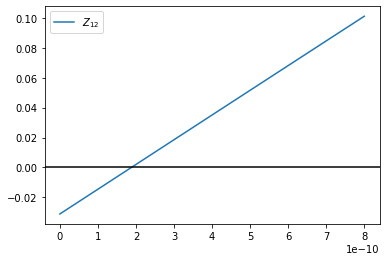

In [35]:
z12 = -0.5 * components_list[:, 3] + np.sqrt(3.) / 2. * components_list[:, 8]
plt.plot(betas, z12, label=r'$Z_{12}$')
plt.axhline(0., color='black')
plt.legend();

In [36]:
idx = np.searchsorted(z12, 0.)
y0, y1 = z12[idx - 1:idx + 1]
x0, x1 = betas[idx - 1:idx + 1]
best_beta_12 = ((0. - y0) * x1 - (0. - y1) * x0) / (y1 - y0)
best_beta_12

1.8787734730626776e-10

In [37]:
hgen.clear_drive()
pulse = qudit_sim.pulse.Drag(duration=duration_12, amp=best_amplitude_12, sigma=sigma_12, beta=best_beta_12)
hgen.add_drive('q0', frequency=drive_frequency_12, amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, log_level=logging.INFO)
components = qudit_sim.apps.gates.gate_components(sim_result)

INFO:qudit_sim.pulse_sim:Using 2272 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 0.642907 seconds.


In [38]:
qudit_sim.visualization.print_components(components, scale='pi')

<IPython.core.display.Latex object>

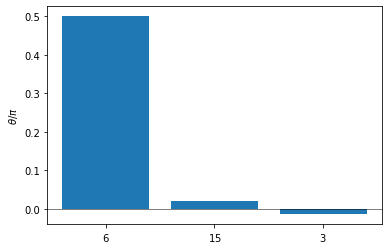

In [39]:
qudit_sim.visualization.plot_components(components, scale='pi');

Let's save the obtained parameters.

In [40]:
import h5py

with h5py.File('pi_pulse/params.h5', 'w') as out:
    out.create_dataset('duration_01', data=duration_01)
    out.create_dataset('sigma_01', data=sigma_01)
    out.create_dataset('amplitude_01', data=best_amplitude_01)
    out.create_dataset('beta_01', data=best_beta_01)
    out.create_dataset('duration_12', data=duration_12)
    out.create_dataset('sigma_12', data=sigma_12)
    out.create_dataset('amplitude_12', data=best_amplitude_12)
    out.create_dataset('beta_12', data=best_beta_12)

The whole exercise is actually automated in `apps.gates.pi_pulse`:

In [41]:
drive_frequency, pi_pulse = qudit_sim.apps.gates.find_pi_pulse(hgen, 'q0', 1, duration_12, sigma_12)

In [42]:
hgen.clear_drive()
hgen.add_drive('q0', frequency=drive_frequency, amplitude=pi_pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist={'points_per_cycle': 8, 'duration': pi_pulse.duration}, log_level=logging.INFO)
components = qudit_sim.apps.gates.gate_components(sim_result)
qudit_sim.visualization.print_components(components, scale='pi')

INFO:qudit_sim.pulse_sim:Using 1142 time points from 0.000e+00 to 3.200e-08
INFO:qudit_sim.pulse_sim:Hamiltonian with 4 terms built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 0.365024 seconds.


<IPython.core.display.Latex object>